<a href="https://colab.research.google.com/github/garrettcl1/portfolio/blob/main/riboseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Overview and references

You will use the provided sequencing reads from a Ribo-seq experiment in Saccharomyces cerevisiae to generate a plot that shows the density of ribosomes along an mRNA sequence. You will perform the following steps

1. Filter out reads corresponding to non-coding RNA (ncRNA) and ribosomal RNA (rRNA) sequences 
2. Use bowtie2 for the alignments 
3. Use Python to analyze the SAM file
4. Use Python to plot the results.


You are expected to keep a thorough record of everything you did in your notebook.


Data from [Weinberg et al (2016)](https://pubmed.ncbi.nlm.nih.gov/26876183/). Workflow courtesy of Lareau lab.

The repo contains three bowtie2 indexes: ScerRRNA (rRNA), rna_coding (ncRNA), and scer_transcriptome (the yeast transcriptome). We will use these indexes to align our reads using Bowtie2.


## Submission checklist

1. Edit this file, add, commit, and push the changes to GitHub.
2. Submit repository link on bCourses.

## Installation

SyntaxError: invalid syntax (3710335962.py, line 3)

In [ ]:
!yes | conda install -c bioconda bowtie2
!pip install pyyaml

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::dbt-core==1.3.0=pyhd8ed1ab_0
  - conda-forge/noarch::dbt-postgres==1.3.0=pyhd8ed1ab_0
  - conda-forge/noarch::dbt-bigquery==1.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::agate==1.6.3=py39hf3d152e_1
  - conda-forge/noarch::python-slugify==8.0.1=pyhd8ed1ab_1
done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - bowtie2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bowtie2-2.2.5              |   py39h7cff6ad_8        14.9 MB  bioconda
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-for

# Background

In this lab, we will use data from a Ribo-seq experiment. In Ribo-seq, each sequencing read represents the position of a ribosome on an mRNA transcript, and allows us to quantify things like ribosome density or translation speed. The details of how the procedure works can be found here (https://www.nature.com/articles/nrg3645), but are not too important for this lab. When we get Ribo-seq reads, there is often contamination from other types of RNA in our sequencing data, like ribosomal RNA (rRNA) or non-coding RNAs (ncRNA), which we want to filter out first. Conveniently, we have a list of rRNA and ncRNA sequences that we can align the reads to, and filter out any unwanted reads. Next, we can align the remaining reads to the yeast transcriptome, and find the position of each ribosome alongall the mRNAs. Let’s start by filtering out unwanted RNA sequences.

# 1. Filter out unwanted RNA reads

You’re going to want to map these reads to the rRNA and ncRNA indexes first to obtain a fastq file of reads that do not align to either index. These are the reads we will align to the yeast transcriptome in Part 2. To do this, check out the sample bowtie2 command from the introduction.

Remember, our reads are unpaired so you should use the `-U` argument.

## 1.1 rRNA

1. What arguments should we use for Bowtie2? 
2. What will you use for the index name?
3. What will you use for the input reads?
4. If you use the `--un unaligned.fastq` option, what will `unaligned.fastq` contain?
5. Do we keep the reads that align or don’t align?

### 1.1 Answer

1. x (path to database), U (path to input reads), S (path to output SAM file)
2. -x ScerRRNA/ScerRRNA
3. -U riboseq_reads.fq
4. reads that couldn't be aligned into a separate FASTQ file
5. we keep both in separate files

In [ ]:
!bowtie2 --very-fast -x ScerRRNA/ScerRRNA \
-U riboseq_reads.fq -S output.sam --un unaligned.fastq
# you can run bash commands here with a ! before the command

702642 reads; of these:
  702642 (100.00%) were unpaired; of these:
    619256 (88.13%) aligned 0 times
    83386 (11.87%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
11.87% overall alignment rate


## 1.2 ncRNA

1. What arguments should we use for Bowtie2? 
2. What will you use for the index name?
3. What will you use for the input reads?
4. If you use the -`-un unaligned.fastq` option, what will `unaligned.fastq` contain?
5. Do we keep the reads that align or don’t align?

### 1.2 Answer

1. x (path to database), U (path to input reads), S (path to output SAM file)
2. -x rna_coding/rna_coding
3. -U riboseq_reads.fq
4. reads that couldn't be aligned into a separate FASTQ file
5. we keep both in separate files

In [ ]:
!bowtie2 --very-fast -x rna_coding/rna_coding \
-U riboseq_reads.fq -S output.sam --un unaligned.fastq
# you can run bash commands here with a ! before the command

702642 reads; of these:
  702642 (100.00%) were unpaired; of these:
    617444 (87.87%) aligned 0 times
    796 (0.11%) aligned exactly 1 time
    84402 (12.01%) aligned >1 times
12.13% overall alignment rate


## 1.3

What percentage of your sequencing library were rRNA reads? What percentage were from ncRNA?

In [ ]:
!bowtie2 --very-fast -x rna_coding/rna_coding \
-U unaligned.fastq -S output.sam 

617444 reads; of these:
  617444 (100.00%) were unpaired; of these:
    617444 (100.00%) aligned 0 times
    0 (0.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
0.00% overall alignment rate


### 1.3 Answer
88.13% and 87.87%



# 2. Align the reads to the S. cerevisiae transcriptome

Now, let’s map the remaining reads to the transcriptome to find out where ribosomes are actively translating. Run bowtie2 again, using the filtered reads you obtained in the previous step as input and the yeasttranscriptome as the index.

## 2.1

1. What arguments should we use for Bowtie2? 
2. What will you use for the index name? 
3. What will you use for the input reads?
4. What do these reads represent in a Ribo-seq experiment?
5. If you use the `--un unaligned.fastq` option, what will `unaligned.fastq` contain?
6. What percentage of your filtered library didn’t align to the reference genome? If you use `--very-sensitive` instead of `--very-fast`, does this percentage increase or decrease?

### 2.1 Answer

1. x (path to database), U (path to input reads), S (path to output SAM file)
2. -x scer_transcriptome
3. -U riboseq_reads.fq
4. filtered reads
5. reads that couldn't be aligned
6. no change

In [ ]:
!bowtie2 --very-fast -x scer_transcriptome/scer.transcripts.13cds10 \
-U riboseq_reads.fq -S output.sam --un unaligned.fastq

702642 reads; of these:
  702642 (100.00%) were unpaired; of these:
    106176 (15.11%) aligned 0 times
    458224 (65.21%) aligned exactly 1 time
    138242 (19.67%) aligned >1 times
84.89% overall alignment rate


# 3. Generate a coverage plot

At this point, you should have a SAM file containing the alignment of your filtered reads to the S. cerevisiae transcriptome. In Ribo-seq experiments, the reads represent the mRNA sequence covered by the ribosome, but we want to know which specific position the ribosome was translating. To do this, we apply an offset that converts the aligned position of the read into the position of the A-site of the ribosome (we won’t get into the details of how this works, but have provided a helper function that does this for you). 

Use the starter code provided to 

1. Build a list for each gene that represents the number of ribosomes present at each position in the transcript. Thus, position `i` in the list will contain the number of ribosomes present for the gene of interest.
2. Build a dictionary of gene -> list of ribosome counts at each position in the gene. Each key will be a gene and each value will be the list from step 1.

In [ ]:
import yaml

# cds_dict is a dictionary of gene_name -> length of transcript
with open('scer_transcriptome/scer.transcripts.13cds10.lengths.txt','r') as flength:
        cds_dict = {}
        for line in flength.readlines():
            line = line.strip().split()
            cds_dict[line[0]] = int(line[2])

def get_gene_coverage(sam):
    """
    Parses a sam file with riboseq reads. 
    
    Assigns A-site offsets (an offset from the start of the riboseq read to the A site position)
    Code adapted from https://github.com/lareaulab/iXnos
    
    Arguments:
        sam -- path to the sam file containing riboseq reads aligned to transcriptome
    Returns:
        Iterator over reads in format (gene, read_sequence, position_in_transcript)
    """
    # loads offset values
    shift_dict = yaml.safe_load(open('ref_asite_offset.yaml','r'))
    #opens sam file for parsing
    in_sam = open(sam, "r")
    for line in in_sam:
        
        if line[0] == "@":                          #ignores comments in sam file
            continue
        line = line.strip().split()
        read = line[9]                              #parses read sequence
        
        if len(read) < 27 or len(read) > 31:        #only consider reads within 27-31 nt
            continue
        gene = line[2]                              #parses read sequence
        
        if gene == '*':
            continue
        utr5_len = 13                               #determines offset value
        map_nt = int(line[3]) - 1 - utr5_len
        frame = map_nt % 3
        shift = shift_dict[len(read)][frame]
        
        if not shift:
            continue
        map_nt += shift                             #converts the alignment position to position in transcript
        
        if map_nt >= 0 and map_nt < cds_dict[gene]:
            yield (gene, read, map_nt)              #if data is valid, iterator outputs read
    in_sam.close()

In [ ]:
cds_dict

{'YAL001C': 3483,
 'YAL002W': 3825,
 'YAL003W': 621,
 'YAL005C': 1929,
 'YAL007C': 648,
 'YAL008W': 597,
 'YAL009W': 780,
 'YAL010C': 1482,
 'YAL011W': 1878,
 'YAL012W': 1185,
 'YAL013W': 1218,
 'YAL014C': 768,
 'YAL015C': 1200,
 'YAL016W': 1908,
 'YAL017W': 4071,
 'YAL018C': 978,
 'YAL019W': 3396,
 'YAL020C': 1002,
 'YAL021C': 2514,
 'YAL022C': 1554,
 'YAL023C': 2280,
 'YAL024C': 4308,
 'YAL025C': 921,
 'YAL026C': 4068,
 'YAL027W': 786,
 'YAL028W': 1587,
 'YAL029C': 4416,
 'YAL030W': 354,
 'YAL031C': 2283,
 'YAL032C': 1140,
 'YAL033W': 522,
 'YAL034C': 1242,
 'YAL034W-A': 870,
 'YAL035W': 3009,
 'YAL036C': 1110,
 'YAL037C-A': 93,
 'YAL037W': 804,
 'YAL038W': 1503,
 'YAL039C': 810,
 'YAL040C': 1743,
 'YAL041W': 2565,
 'YAL042W': 1248,
 'YAL043C': 2358,
 'YAL044C': 513,
 'YAL044W-A': 333,
 'YAL046C': 357,
 'YAL047C': 1869,
 'YAL048C': 1989,
 'YAL049C': 741,
 'YAL051W': 3144,
 'YAL053W': 2352,
 'YAL054C': 2142,
 'YAL055W': 543,
 'YAL056W': 2643,
 'YAL058W': 1509,
 'YAL059W': 639,
 'YAL06

In [ ]:
iterator = get_gene_coverage('output.sam')

emptydict = {}
for x in cds_dict.keys():
    emptydict[x] = cds_dict[x]*[0]
    
for x in iterator:
    curr_position = x[2]
    curr_gene = x[0]
    emptydict[curr_gene][curr_position] += 1

## 3.1

1. What gene has the most ribosomes? 
2. Are there any genes with zero ribosomes? 
3. What is the average number of ribosomes per gene across the transcriptome?

In [ ]:
most_ribosomes = 0
for key, value in emptydict.items():
    if sum(value)> most_ribosomes:
        gene= key
        most_ribosomes = sum(value)
print(gene, most_ribosomes)

YLR044C 16584


In [ ]:
min_ribosomes = 16584
for key, value in emptydict.items():
    if sum(value)< min_ribosomes:
        min_ribosomes = sum(value)
        gene = key
print(gene, min_ribosomes)

YAL018C 0


In [ ]:
total= 0
for key, value in emptydict.items():
    total += sum(value)
average = total/len(emptydict)
    
print(average)

99.79521547336275


### 3.1 Answer

1. YLR044C 16584
2. YAL018C 0
3. 99.79521547336275

## 3.2

Now we want to visualize the density of ribosomes. To do this, we will visualize the aggregate number of ribosomes at each position relative to the start codon across the transcriptome.  To do this, we will build a new array which is as large as the longest transcript. In each position `i` in the array, we will store the sum of ribosome counts at position `i` for all the genes in the transcriptome. 

Note: it would be difficult to visualize the density of ribosomes for every transcript, so this way we can visualize the trend across the transcriptome in a single plot.

Once you generate this array, use matplotlib (or seaborn or pandas) to generate a bar plot where the x-axis is position and the y-axis is number of ribosomes. To visualize the trends better, just plot the first 500nt positions. Also, make a bar plot of just the first 100 nucleotides.

In [ ]:
longest_trans = 0
for key, value in emptydict.items():
    if len(value)> longest_trans:
        gene= key
        longest_trans = len(value)
print(gene, longest_trans)

YLR106C 14733


In [ ]:
density = []
for value in cds_dict.values():
    density.append(value)

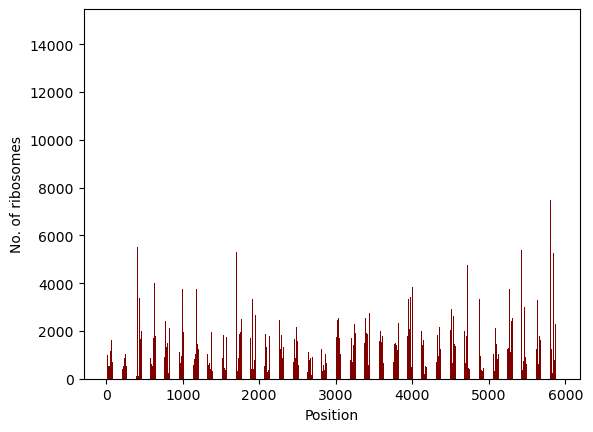

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.bar([i for i in range(len(density))], density, color ='maroon',
        width = 0.4)
 
plt.xlabel("Position")
plt.ylabel("No. of ribosomes")
plt.show()